In [3]:
import numpy as np
from PIL import Image
import os
from random import randrange
from matplotlib import pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [4]:
path = "IIIT-CFW"

cfw_dict = {
    'AamirKhan': 0,
    'AishwaryaRai': 1,
    'Amitabhbachan': 2,
    'BarackObama': 3,
    'DwayneJohnson': 4,
    'ManmohanSingh': 5,
    'NarendraModi': 6,
    'VladimirPutin': 7
}
        
opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

def display_images(imgs,classes,row=1,col=2,w=32,h=32):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

def load_data(dir_path):
    image_list = []
    y_list = []
    label_dict = cfw_dict
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue
    image_list = np.array(image_list)
    y_list = np.array(y_list)
    print("Dataset shape:",image_list.shape)
    print("Label shape:",y_list.shape)

    return image_list,y_list

In [5]:
class PCA:
    def __init__(self, data_X, data_y, n_components=2):
        self.n_components = n_components
        self.X = data_X
        self.y = data_y
        
    def pca(self):
        self.N = self.X.shape[0]
        self.X = self.X.reshape((self.N, -1))

        self.X_mean = np.mean(self.X, axis=0)
        self.X_centered = self.X - self.X_mean

        self.cov_matrix = np.cov(self.X_centered, rowvar=False)
        self.eigenvalues, self.eigenvectors = np.linalg.eigh(self.cov_matrix)

        sorted_indices = np.argsort(self.eigenvalues)[::-1]
        self.eigenvalues = self.eigenvalues[sorted_indices]
        self.eigenvectors = self.eigenvectors[:, sorted_indices]

        self.top_eigenvectors = self.eigenvectors[:, 0:self.n_components]

        self.X_pca = np.dot(self.top_eigenvectors.transpose(), self.X_centered.transpose()).transpose()
        return self.X_pca, self.y

In [6]:
def plot_var_explained():
    explained_variance = np.cumsum(pca_class.eigenvalues) / np.sum(pca_class.eigenvalues)
    num_components = np.arange(1, len(explained_variance) + 1)
    plt.figure(figsize=(12, 6))
    plt.plot(num_components, explained_variance, marker='o', linestyle='-', color='black')
    plt.xlabel("Number of components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("Cumulative Explained Variance vs Number of components")
    plt.grid(True)
    plt.show()

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)


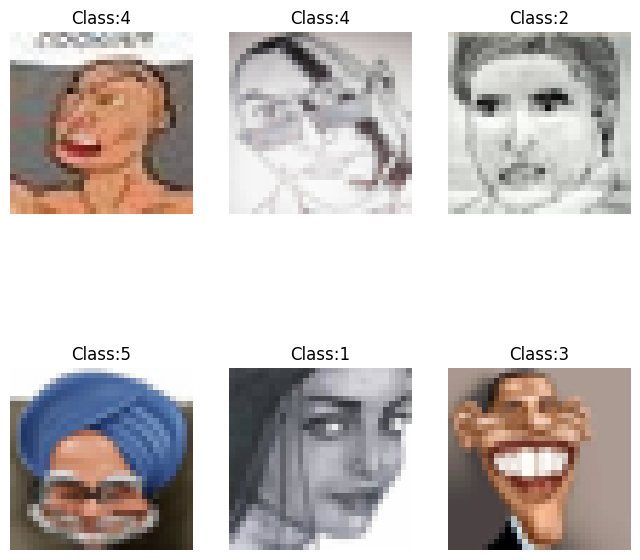

In [7]:
X, y = load_data(path)

N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

ind = np.random.randint(0,y.shape[0],6)
display_images(X[ind,...],y[ind], row=2,col=3)

In [8]:
pca_class = PCA(X, y, n_components=2)
X_pca, y = pca_class.pca()

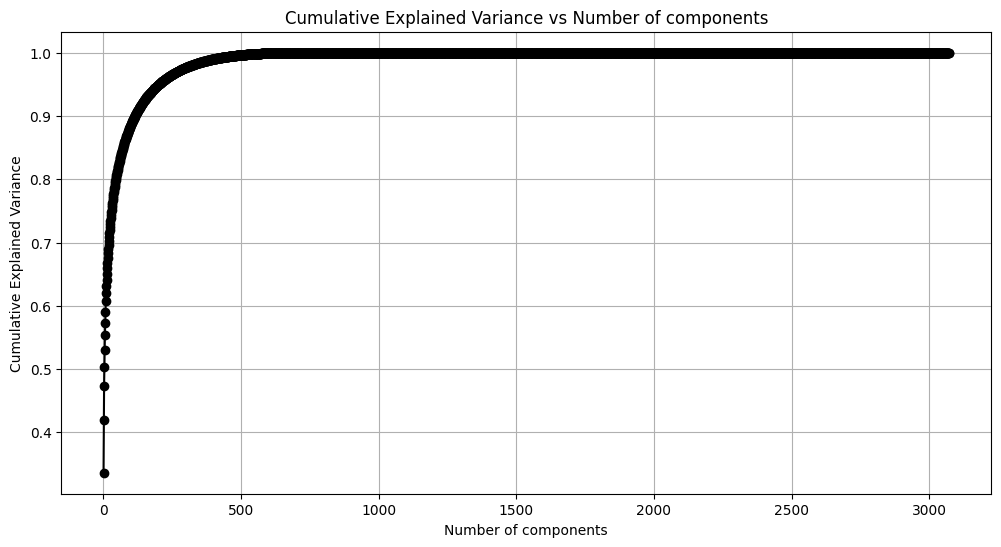

In [9]:
plot_var_explained()

In [10]:
data = np.load('data.npy', allow_pickle=True)
data_df = pd.DataFrame(data)

In [11]:
data_X = np.array(data_df.iloc[:, 2].values.tolist())
data_y = data_df.iloc[:, 3].values

pca_class = PCA(data_X, data_y, n_components=100)
X_projected, y = pca_class.pca()

data_df['VIT_reduced'] = list(X_projected)

### Metrics for reduced dataset

In [12]:
X_reduced = np.array(data_df['VIT_reduced'].values.tolist())
X_reduced = X_reduced.reshape(X_reduced.shape[0], -1)
y = data_y

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42, shuffle=False)
knn = KNeighborsClassifier(n_neighbors=12, metric="manhattan")
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1_micro = f1_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

In [13]:
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score (Micro): ", f1_micro)
print("F1 Score (Macro): ", f1_macro)
print("F1 Score (Weighted): ", f1_weighted)

Accuracy:  0.2833333333333333
Precision:  0.6112715646926173
Recall:  0.2833333333333333
F1 Score (Micro):  0.2833333333333333
F1 Score (Macro):  0.15764268029489906
F1 Score (Weighted):  0.2443202051359946


Reducing the number of components from 512 to 100 did not significantly impact accuracy, with only a slight decrease. This suggests that the reduction in dimensionality did not have a substantial effect on the overall classification accuracy.
Precision improved when reducing the number of components. Recall remained relatively constant, indicating that the ability of the model to identify positive instances did not change significantly when reducing components. 
The micro F1 score considers global counts of true positives, false positives, and false negatives. he macro F1 score calculates the F1 score for each class separately and then takes the average. he weighted F1 score considers class imbalance and showed a decrease when reducing components, suggesting that the model's performance suffered slightly when accounting for class weights.
Reducing the number of components can simplify the model and potentially make it more interpretable and efficient, but it might come at the cost of some loss in predictive performance.


### Accuracy without PCA using KNN Classifier (VIT Dataset)

In [14]:
x = np.array(data_df[2].values.tolist())
x = x.reshape(x.shape[0], -1)
y = data_y

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=False)
knn = KNeighborsClassifier(n_neighbors=12, metric="manhattan")
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

accuracy_no_pca = accuracy_score(y_test, y_pred)

### Accuracy with PCA using KNN Classifier (VIT Dataset)

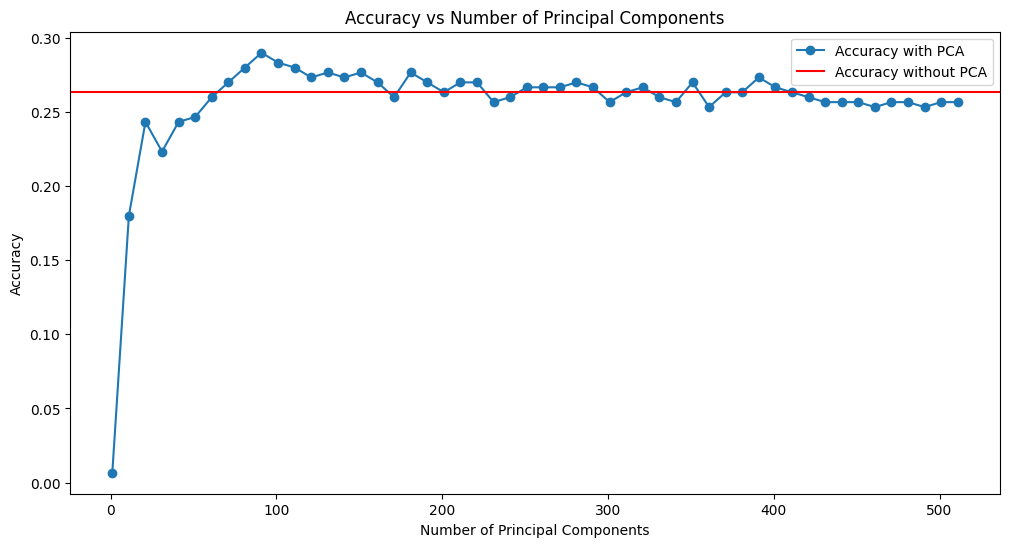

In [15]:
num_components_list = []
accuracy_list = []

for num in range(1, 513, 10):
    data_x = np.array(data_df.iloc[:, 2].values.tolist())
    data_y = data_df.iloc[:, 3].values
    
    pca_class = PCA(data_X, data_y, n_components=num)
    x, y = pca_class.pca()
    data_df['VIT_reduced'] = list(x)
    
    X_reduced = np.array(data_df['VIT_reduced'].values.tolist())
    X_reduced = X_reduced.reshape(X_reduced.shape[0], -1)

    X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42, shuffle=False)
    knn = KNeighborsClassifier(n_neighbors=12, metric="manhattan")
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list.append(accuracy)
    num_components_list.append(num)
    
plt.figure(figsize=(12, 6))
plt.plot(num_components_list, accuracy_list, marker='o', linestyle='-', label='Accuracy with PCA')
plt.axhline(y=accuracy_no_pca, color='r', label='Accuracy without PCA')
plt.xlabel("Number of Principal Components")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Principal Components")
plt.legend()
plt.show()

### Accuracy Pre-dimensionality Reduction (CFW Dataset)

In [16]:
X, y = load_data(path)

N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)


In [17]:
X, y = load_data(path)
X_reshape = X.reshape(X.shape[0], -1)

X_train, X_test, y_train, y_test = train_test_split(X_reshape, y, test_size=0.2, random_state=42)
knn = KNeighborsClassifier(n_neighbors=12)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

accuracy_no_pca_cfw = accuracy_score(y_test, y_pred)
print("Accuracy without PCA:", accuracy_no_pca_cfw)

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)
Accuracy without PCA: 0.37777777777777777


### Accuracy Post-dimensionality Reduction (CFW Dataset)

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)


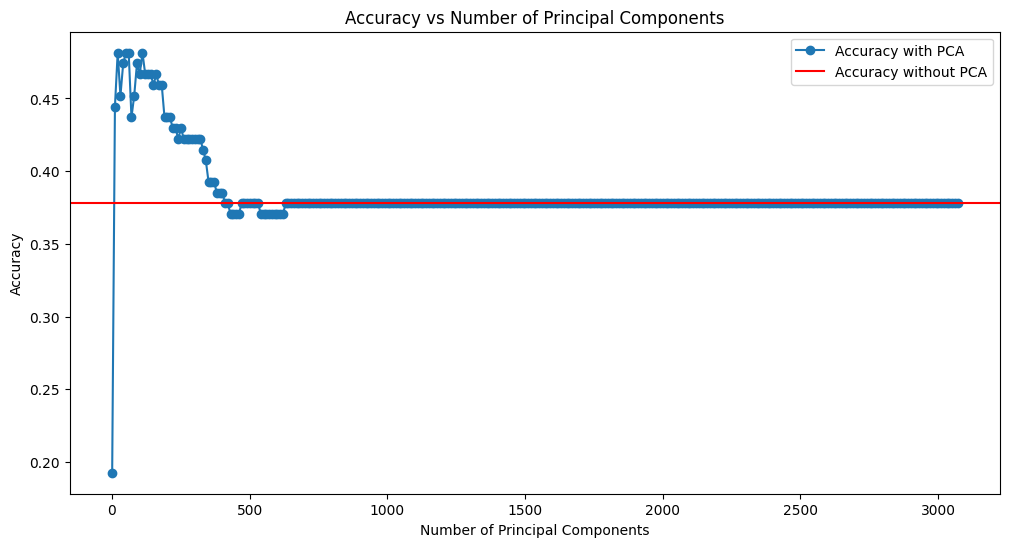

In [126]:
num_components_list_cfw = []
accuracy_list_cfw = []

X, y = load_data(path)
N, H, W, C = X.shape

for num in range(1, 3072, 10):
    pca = PCA(X, y, n_components=num)
    X_pca, y = pca.pca()
    X_pca = X_pca.reshape(X_pca.shape[0], -1)

    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

    knn = KNeighborsClassifier(n_neighbors=12)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    num_components_list_cfw.append(num)
    accuracy_list_cfw.append(accuracy)
    
plt.figure(figsize=(12, 6))
plt.plot(num_components_list_cfw, accuracy_list_cfw, marker='o', linestyle='-', label='Accuracy with PCA')
plt.axhline(y=accuracy_no_pca_cfw, color='r', label='Accuracy without PCA')
plt.xlabel("Number of Principal Components")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Principal Components")
plt.legend()
plt.show()

### 1.2 Pictionary Dataset

In [18]:
guesser_df = pd.read_csv('guesser_attributes.csv')
drawer_df = pd.read_csv('drawer_attributes.csv')

In [19]:
drawer_X = drawer_df.iloc[:, 1:].values
drawer_y = drawer_df.iloc[:, 0].values

guesser_X = guesser_df.iloc[:, 1:].values
guesser_y = guesser_df.iloc[:, 0].values

In [20]:
pca_class_drawer = PCA(drawer_X, drawer_y, n_components=2)
drawer_X_pca, drawer_y_pca = pca_class_drawer.pca()

pca_class_guesser = PCA(guesser_X, guesser_y, n_components=2)
guesser_X_pca, guesser_y_pca = pca_class_guesser.pca()

In [29]:
loading_matrix_drawer = pca_class_drawer.top_eigenvectors
loading_matrix_guesser = pca_class_guesser.top_eigenvectors

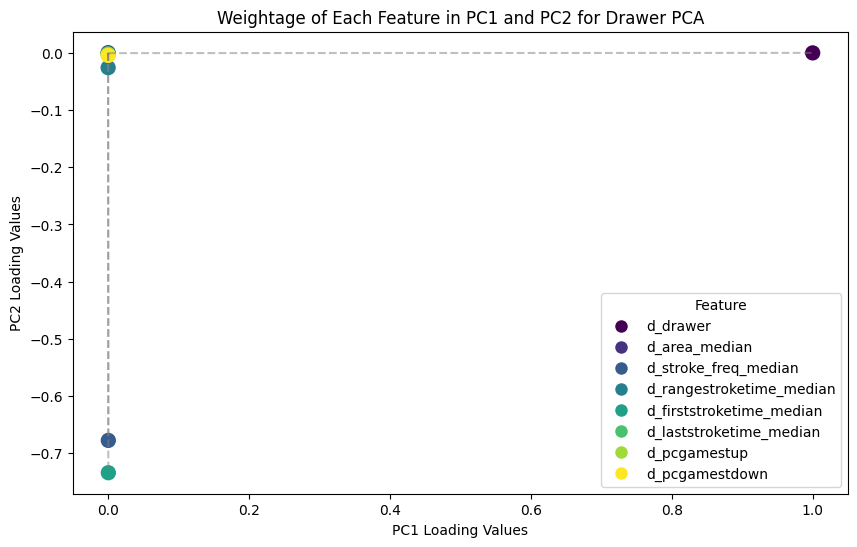

In [36]:
loading_values_pc1 = loading_matrix_drawer[:, 0]
loading_values_pc2 = loading_matrix_drawer[:, 1]

feature_names = drawer_df.columns
colors = np.arange(len(loading_values_pc1))

plt.figure(figsize=(10, 6))
scatter = plt.scatter(loading_values_pc1, loading_values_pc2, c=colors, cmap='viridis', marker='o', s=100)

for i, (x, y) in enumerate(zip(loading_values_pc1, loading_values_pc2)):
    plt.plot([0, x], [0, y], linestyle='--', color='gray', alpha=0.5)

plt.title('Weightage of Each Feature in PC1 and PC2 for Drawer PCA')
plt.xlabel('PC1 Loading Values')
plt.ylabel('PC2 Loading Values')

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(c)), markersize=10, label=feature_names[i]) for i, c in enumerate(colors)]
plt.legend(handles=handles, title='Feature')

plt.show()

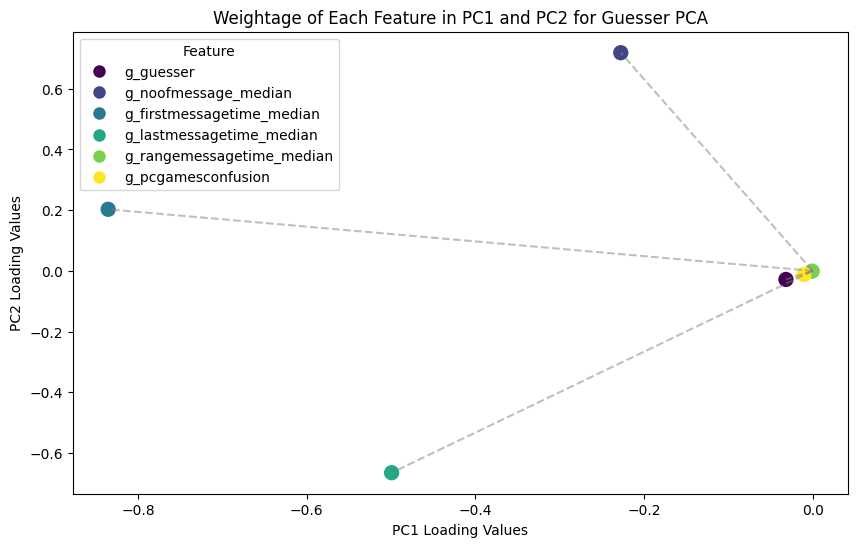

In [38]:
loading_values_pc1 = loading_matrix_guesser[:, 0]
loading_values_pc2 = loading_matrix_guesser[:, 1]

feature_names = guesser_df.columns
colors = np.arange(len(loading_values_pc1))

plt.figure(figsize=(10, 6))
scatter = plt.scatter(loading_values_pc1, loading_values_pc2, c=colors, cmap='viridis', marker='o', s=100)

for i, (x, y) in enumerate(zip(loading_values_pc1, loading_values_pc2)):
    plt.plot([0, x], [0, y], linestyle='--', color='gray', alpha=0.5)

plt.title('Weightage of Each Feature in PC1 and PC2 for Guesser PCA')
plt.xlabel('PC1 Loading Values')
plt.ylabel('PC2 Loading Values')

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(c)), markersize=10, label=feature_names[i]) for i, c in enumerate(colors)]
plt.legend(handles=handles, title='Feature')

plt.show()

Each of the new axes obtained from PCA represents a specific direction in the original data space that encapsulates important information about the dataset. PC1, the first principal component, corresponds to the direction along which there is the most variance, capturing the dominant structure or pattern in the data. PC2, the second principal component, represents the second most significant direction of variance, orthogonal to PC1. These components are linear combinations of the original features, with their associated loading values indicating the weight or contribution of each feature to the respective PC. Each new axis, or principal component, extracted from PCA reveals distinctive aspects of the data, enabling dimensionality reduction and a deeper understanding of its underlying structure.